In [1]:
import logging
from Online_Update import test_then_train_env
from Online_Models import (Online_Diffusion, Online_Xgboost, Online_MA, ELM, Online_GCN,
                           Online_GAT, Online_LSTM, Online_Diffusion_Density, Single_Model, 
                           Online_Diffusion_UQ, Online_LSTM_Single)
from lib.utils import gen_data_dict, process_sensor_data
from lib.utils import seperate_up_down
import random
import torch
import numpy as np # only run this when using delftblue
from dgl.data.utils import load_graphs
import pickle


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
random.seed(1)
df_dict = {}
# Define path to parent directory containing subdirectories with CSV files

# online testing
# dataset_name = "crossroad"
# dataset_name = "train_station"
dataset_name = "maze"
parent_dir = 'sc_sensor'
if dataset_name == "maze":
    with open("./sc_sensor/maze/flow_data.pkl", "rb") as f:
        data_dict = pickle.load(f)
else:
    df_dict = process_sensor_data(parent_dir, df_dict)
    data_dict = gen_data_dict(df_dict)
    data_dict = seperate_up_down(data_dict)

# test_sc = ['sc_sensor/crossroad1', 'sc_sensor/crossroad2', 'sc_sensor/crossroad4', 'sc_sensor/crossroad5',
#            'sc_sensor/crossroad1', 'sc_sensor/crossroad10', 'sc_sensor/crossroad11', 'sc_sensor/crossroad8', 'sc_sensor/crossroad2_2']

# test_sc = ['sc_sensor/crossroad2', 'sc_sensor/crossroad4', 'sc_sensor/crossroad5']
# train_sc = ['sc_sensor/train3']

# test_sc = ['sc_sensor/train1','sc_sensor/train3', 'sc_sensor/train5',
#            'sc_sensor/train2', 'sc_sensor/train6', 'sc_sensor/train4',
#            'sc_sensor/train1_2', 'sc_sensor/train7']

#seperate upstream and downstream
# data_dict = seperate_up_down(data_dict)
g_data = load_graphs('./graphs/graphs.bin')
if dataset_name == "crossroad":
    g = g_data[0][0]
    test_sc = ['sc_sensor/crossroad1', 'sc_sensor/crossroad2', 'sc_sensor/crossroad4', 'sc_sensor/crossroad5',
               'sc_sensor/crossroad1', 'sc_sensor/crossroad10', 'sc_sensor/crossroad11', 'sc_sensor/crossroad8',
               'sc_sensor/crossroad2_2', 'sc_sensor/crossroad6', 'sc_sensor/crossroad7', 'sc_sensor/crossroad9',]
    inbound_node = [0, 3, 5, 6]
    outbound_node = [1, 2, 4, 7]
    node_of_interest = outbound_node

    
elif dataset_name == "train_station":
    g = g_data[0][1]
    test_sc = ['sc_sensor/train1', 'sc_sensor/train3', 'sc_sensor/train5', 'sc_sensor/train11',
               'sc_sensor/train2', 'sc_sensor/train6', 'sc_sensor/train4', 'sc_sensor/train12',
               'sc_sensor/train1_2', 'sc_sensor/train7', 'sc_sensor/train8', 'sc_sensor/train13',
               'sc_sensor/train9', 'sc_sensor/train10']
    inbound_node = [3, 7, 4, 8, 11, 14, 17, 18, 21, 0]
    outbound_node = [2, 6, 5, 9, 10, 15, 16, 19, 20, 1]
    node_of_interest = outbound_node + [22, 23, 12, 13]
    
elif dataset_name == "maze":
    g = g_data[0][2]
    test_sc = ['sc_sensor/maze14', 'sc_sensor/maze2', 'sc_sensor/maze3', 'sc_sensor/maze1', 'sc_sensor/maze8',
               'sc_sensor/maze17', 'sc_sensor/maze16', 'sc_sensor/maze15', 'sc_sensor/maze19', 'sc_sensor/maze12',
               'sc_sensor/maze8_2', 'sc_sensor/maze10_2', 'sc_sensor/maze18', 'sc_sensor/maze13', 'sc_sensor/maze20']
    inbound_node = [3, 0, 18, 20, 14, 13, 9, 7]
    outbound_node = [2, 1, 19, 21, 15, 12, 8, 6]
    node_of_interest = outbound_node + [4, 5, 22, 23, 16, 17, 11, 10]
    
# if dataset_name == "crossroad":
#     file_path = 'graphs/graph_data_crossroad.pkl'
#     with open(file_path, 'rb') as file:
#         g = pickle.load(file)
# 
# elif dataset_name == "train_station":
#     file_path = 'graphs/graph_data_trainstation.pkl'
#     with open(file_path, 'rb') as file:
#         g = pickle.load(file)

chunk_size = 30
lags = 5
'''Has to >= 2'''
pred_horizon = 7 # 3, 5
# test_env = test_then_train_env(data_dict, test_sc, chunk_size, pred_horizon, lags=lags, g=g)
test_env = test_then_train_env(data_dict, test_sc, chunk_size, pred_horizon, lags=lags, g=g, logger=logger)
test_env.device = device

In [21]:
mdl = "ma"
# mdl = "diffusion"
# mdl = "diffusion_uq"
# mdl = "diffusion_density"
# mdl = "xgboost"
# mdl = "elm"
# mdl = "gcn"
# mdl = "gat"
# mdl = "lstm"
# mdl = "lstm_sig"
if mdl == "diffusion":
    model = Single_Model(model_type=Online_Diffusion, dataset=dataset_name, g=g, pred_horizon=pred_horizon, lags=lags, device=device, 
                         chunk_size=chunk_size, train_steps=130, buffer=True)
elif mdl == "xgboost":
    model = Single_Model(model_type=Online_Xgboost, g=g, dataset=dataset_name, pred_horizon=pred_horizon,
                         lags=lags, device=device, chunk_size=chunk_size, train_steps=None, buffer=False)
elif mdl == "ma":
    model = Single_Model(model_type=Online_MA, g=g, pred_horizon=pred_horizon, lags=lags, device=device,
                         chunk_size=chunk_size, train_steps=None)
elif mdl == "elm":
    model = Single_Model(model_type=ELM, g=g, pred_horizon=pred_horizon, lags=lags, device=None, hidden_units=64, train_steps=None, buffer=False)
elif mdl == "gcn":
    model = Single_Model(model_type=Online_GCN, chunk_size=chunk_size, g=g, pred_horizon=pred_horizon, 
                         lags=lags, device=device, hidden_units=128, train_steps=100)
elif mdl == "gat":
    model = Single_Model(model_type=Online_GAT, g=g, hidden_units=32, pred_horizon=pred_horizon, 
                         lags=lags, device=device, num_heads=3, train_steps=200, chunk_size=chunk_size)
elif mdl == "lstm":
    model = Single_Model(model_type=Online_LSTM, g=g, pred_horizon=pred_horizon, 
                         lags=lags, device=device, hidden_units=64, chunk_size=chunk_size, num_layers=2, train_steps=200, buffer=True)
elif mdl == "lstm_sig":
    model = Single_Model(model_type=Online_LSTM_Single, g=g, pred_horizon=pred_horizon, lags=lags, device=device, hidden_units=32,
                     chunk_size=chunk_size, num_layers=2, train_steps=200, buffer=True)
elif mdl == "diffusion_uq":
    model = Single_Model(model_type=Online_Diffusion_UQ, g=g, pred_horizon=pred_horizon, lags=lags, device=device,
                         train_steps=130, chunk_size=chunk_size, buffer=True)
elif mdl == "diffusion_density":
    model = Single_Model(model_type=Online_Diffusion_Density, g=g, pred_horizon=pred_horizon, lags=lags, device=device, 
                         chunk_size=chunk_size, train_steps=150, buffer=True)
else:
    raise ValueError("model type not found")
# model, curve_data, preds[mdl] = test_env.test_then_train(model)
model, curve_data, preds[mdl], v, alpha, e = test_env.test_then_train(model)
# error_dict[mdl] = curve_data
model_dict[mdl] = model
if mdl in ["diffusion", "diffusion_uq", "diffusion_density"]:
    v_dict[mdl] = torch.cat(v, dim=1).detach().numpy()
    alpha_dict[mdl] = torch.cat(alpha, dim=1).detach().numpy()
    e_dict[mdl] = torch.cat(e, dim=1).detach().numpy()

2024-05-18 12:10:53,174 - INFO - error per sc_sensor/maze14 chunk: 0: 2.1667909622192383
2024-05-18 12:10:53,176 - INFO - error per sc_sensor/maze14 chunk: 30: 1.9459425210952759
2024-05-18 12:10:53,177 - INFO - error per sc_sensor/maze14 chunk: 60: 1.6747550964355469
2024-05-18 12:10:53,178 - INFO - error per sc_sensor/maze14 chunk: 90: 1.9420056343078613
2024-05-18 12:10:53,180 - INFO - error per sc_sensor/maze14 chunk: 120: 2.2039313316345215
2024-05-18 12:10:53,181 - INFO - error per sc_sensor/maze14 chunk: 150: 2.199450969696045
2024-05-18 12:10:53,182 - INFO - error per sc_sensor/maze14 chunk: 180: 2.143224000930786
2024-05-18 12:10:53,183 - INFO - error per sc_sensor/maze14 chunk: 210: 1.6751866340637207
2024-05-18 12:10:53,184 - INFO - error per sc_sensor/maze14 chunk: 240: 1.759171724319458
2024-05-18 12:10:53,186 - INFO - error per sc_sensor/maze14 chunk: 270: 1.805497646331787
2024-05-18 12:10:53,187 - INFO - error per sc_sensor/maze14 chunk: 300: 1.7491008043289185
2024-05-

## Load Prediction and Ground Truth

In [3]:
# model_list = ["Online_Diffusion", "Online_Diffusion_UQ", "Online_Xgboost", "Online_MA", "ELM", "Online_GCN", 
#               "Online_GAT", "Online_LSTM", "Online_Diffusion_Density", "Online_LSTM_Single"]
preds = {}
error_dict = {}
model_dict = {}

model_list = ["Online_Diffusion", "Online_MA", "Online_GCN", "Online_GAT", "Online_LSTM"]
# train_steps = 130
for m in model_list:
    
    try:
        error_dict[m] = np.load(f"checkpoint/{m}_{dataset_name}_curve_error_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.npy")
        preds[m] = np.load(f"checkpoint/{m}_{dataset_name}_prediction_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.npy")
    except:
        print(f"model_{m}, file not found")
        continue


# Load Label

In [4]:
from lib.utils import sliding_win  # to get the online label
label_list = []
sigma_list = []
sc_shift_signal = []
# model = model_dict["diffusion_uq"]
for sc in test_sc:
    data = data_dict[sc]

    observation, label = sliding_win(data, lags=test_env.lags, horizons=test_env.pred_horizon)
    observation, label = torch.FloatTensor(observation).permute(2, 0, 1), torch.FloatTensor(label).permute(2, 0, 1)
    for i in range(0, observation.shape[1] - test_env.chunk_size, test_env.chunk_size):
        # pred = model.predict(observation[:, i:i+chunk_size, :])
        try:
            sigma_list.append(model.model.g.ndata['sigma'])
        except:
            pass
        label_list.append(label[:, i:i+test_env.chunk_size, :])
    sc_shift_signal.append(len(label_list) * test_env.chunk_size)

    
labels = torch.stack(label_list, dim=0)
sigma = torch.stack(sigma_list, dim=0).detach()

RuntimeError: stack expects a non-empty TensorList

In [5]:
# visualize preds and labels
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

label = np.transpose(labels, [0, 2, 1, 3]).reshape(-1, labels.shape[1], labels.shape[3])

def visualize(mdl, preds, label, step, node, start=0, time=1000):

    pred = np.transpose(preds[mdl], [0, 2, 1, 3]).reshape(-1, preds[mdl].shape[1], preds[mdl].shape[3]) # [batch, node, horizon]
    plt.figure(figsize=(20, 5))
    # x = np.arange(time - start)
    label = label[start:time, node, step]
    pred = pred[start:time, node, step]
    x = np.arange(len(label))
    sns.lineplot(x=x, y=label, label='label')
    sns.lineplot(x=x, y=pred, label='pred')
    # if mdl == "diffusion_uq":
    #     # sigma = torch.stack(sigma_list, dim=0)
    #     sig = sigma.permute(2, 0, 1).reshape([-1, sigma.shape[1]]).numpy()
    #     sig = np.sqrt(pred[:, :, step] + pred[:, :, step] ** 2 * sig)
    #     plt.fill_between(x, pred[start:time, node, 0] - 2 * sig[start:time, node], pred[start:time, node, 0] + 2 * sig[start:time, node], alpha=0.5)

    #limit
    plt.ylim(0, 35)
    #rmse
    rmse = np.sqrt(np.mean((label.numpy() - pred) ** 2))
    plt.title(f"{mdl} node {node} step {step} rmse: {rmse}")

In [168]:
total_flow = np.sum(label.numpy(), axis=-1)
# total_inflow = np.sum(total_flow[:, test_env.src_idx], axis=-1)
# total_outflow = np.sum(total_flow[:, test_env.dst_idx], axis=-1)

total_inflow = np.sum(total_flow[:, inbound_node], axis=-1)
total_outflow = np.sum(total_flow[:, outbound_node], axis=-1)
peoples = total_inflow - total_outflow

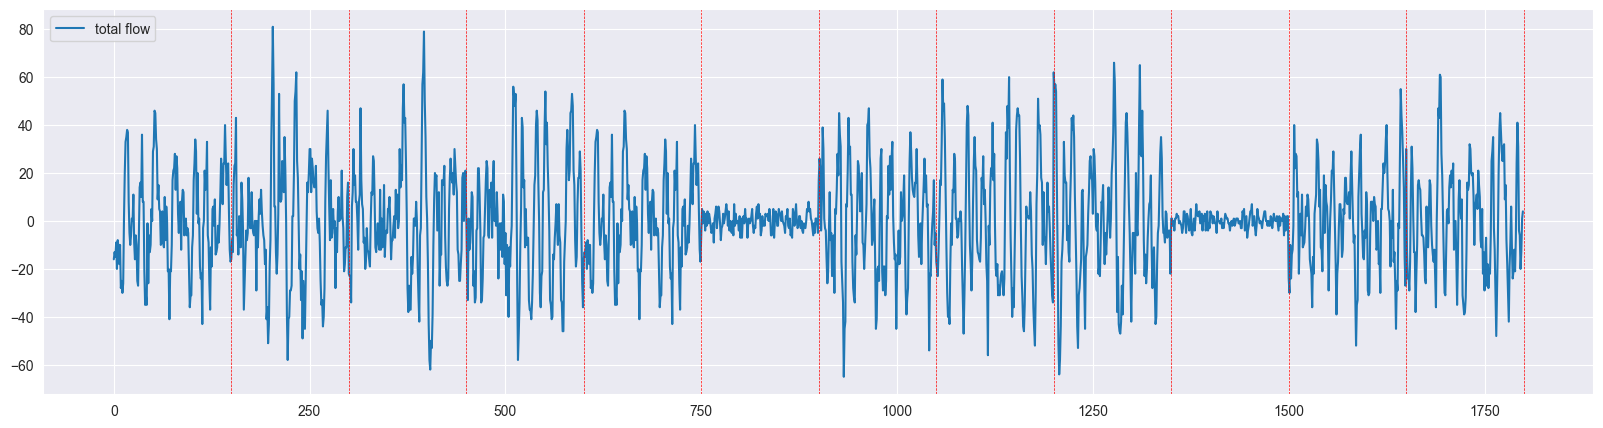

In [169]:
# visualize total flow
start = 0
time = 5000
plt.figure(figsize=(20, 5))
y = peoples[start:time]
x = np.arange(len(y))
sns.lineplot(x=x, y=y, label='total flow')
# decide the end of sc_shift_signal according to time
sc_shift = [i for i in sc_shift_signal if i < time]
for i in sc_shift:
    plt.axvline(x=i, color='r', linestyle='--', linewidth=0.5)

In [211]:
preds["Online_Diffusion"].shape, label.shape

((154, 24, 30, 6), torch.Size([4620, 24, 6]))

In [6]:
node_id = 2
step = 0
visualize("Online_Diffusion", preds, label, step, node_id, start=start, time=time)
sc_shift = [i for i in sc_shift_signal if i < time and i > start]
for i in sc_shift:
    plt.axvline(x=i, color='r', linestyle='--', linewidth=0.5)

NameError: name 'start' is not defined

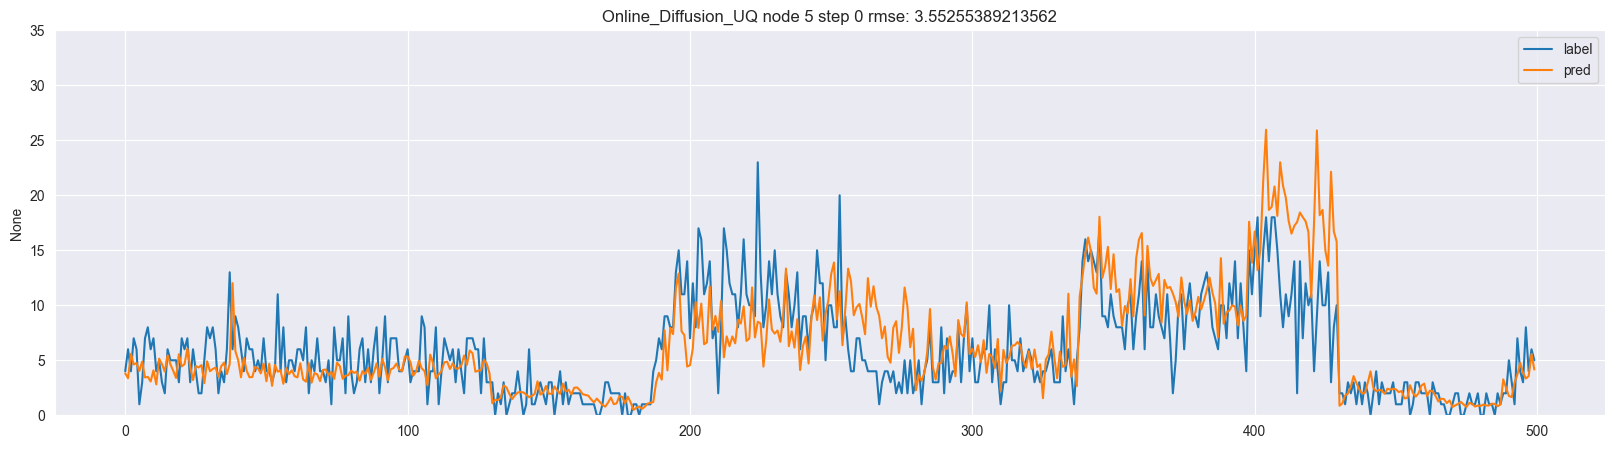

In [430]:
visualize("Online_Diffusion_UQ", preds, label, step, node_id, start=start, time=time)

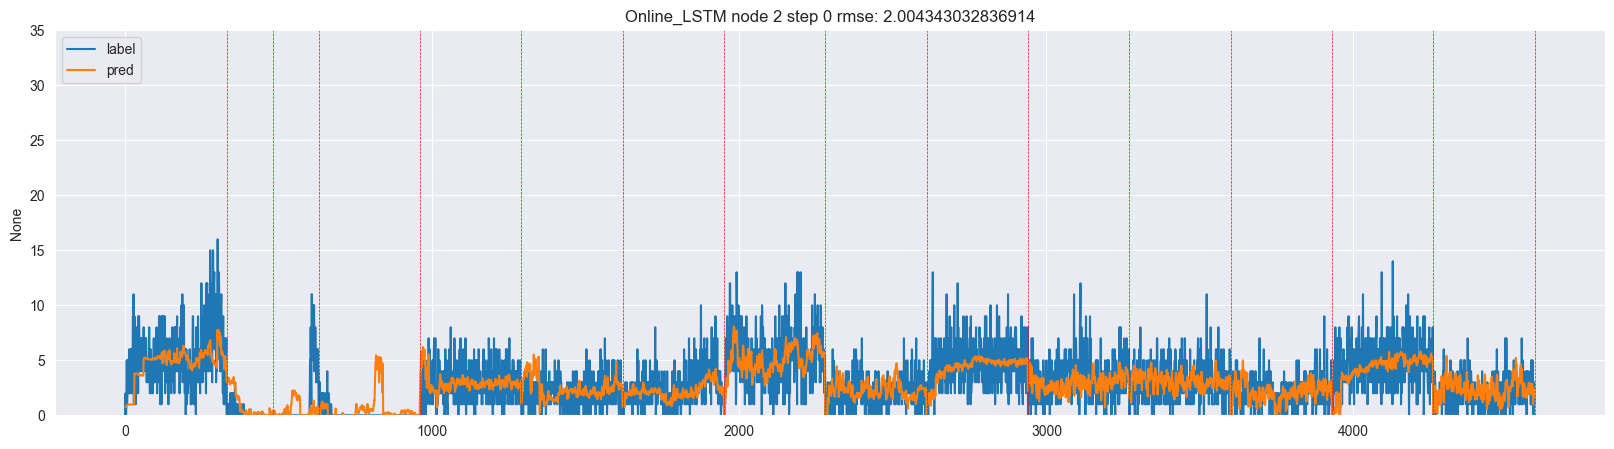

In [143]:
visualize("Online_LSTM", preds, label, step, node_id, start=start, time=time)
sc_shift = [i for i in sc_shift_signal if i < time and i > start]
for i in sc_shift:
    plt.axvline(x=i, color='r', linestyle='--', linewidth=0.5)

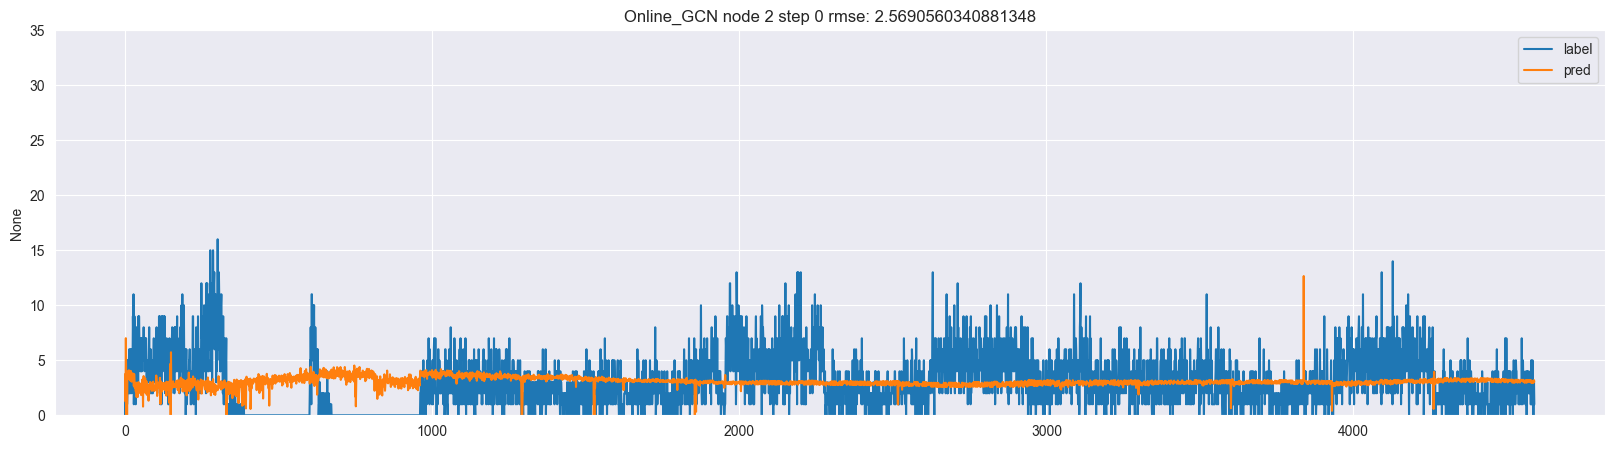

In [154]:
visualize("Online_GCN", preds, label, step, node_id, start=start, time=time)

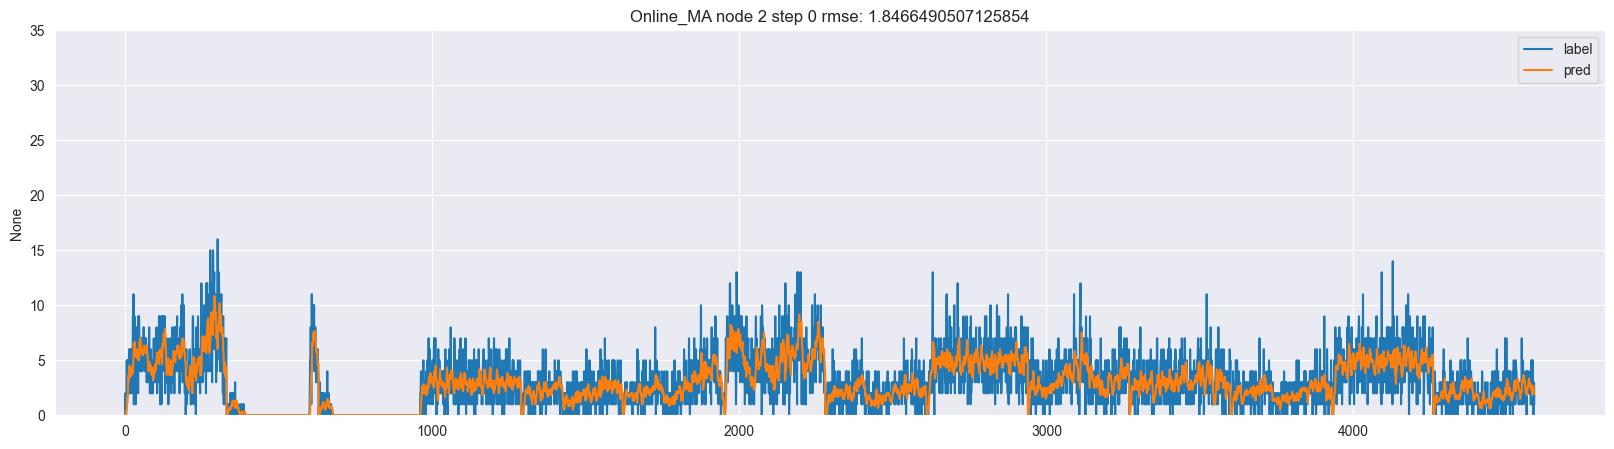

In [147]:
visualize("Online_MA", preds, label, step, node_id, start=start, time=time)

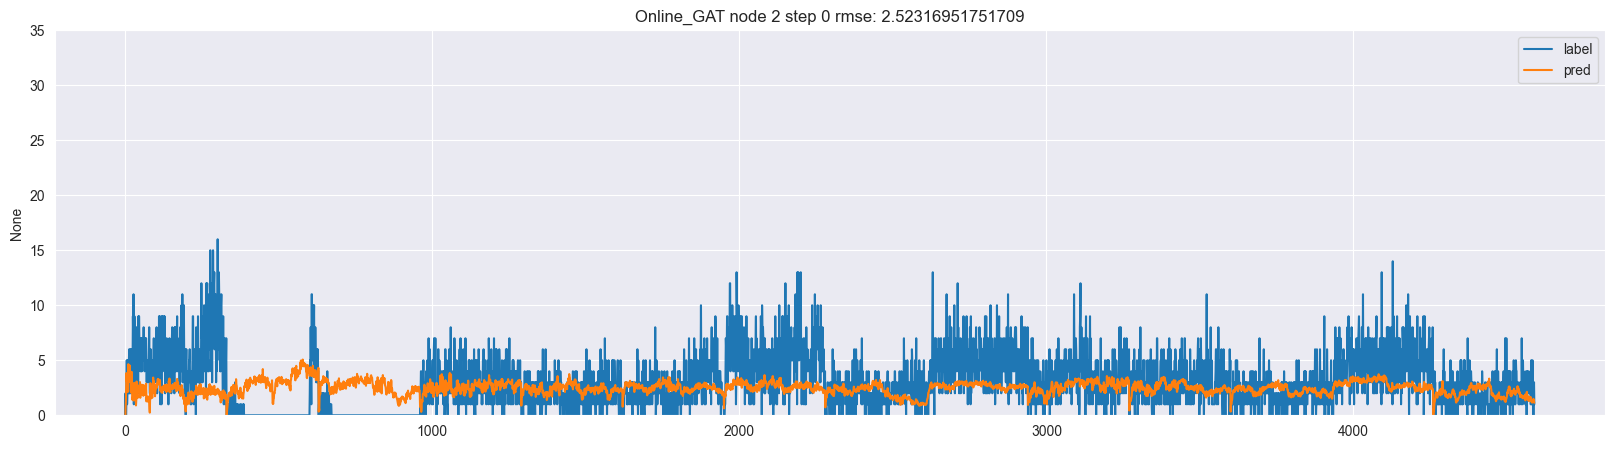

In [153]:
visualize("Online_GAT", preds, label, step, node_id, start=start, time=time)

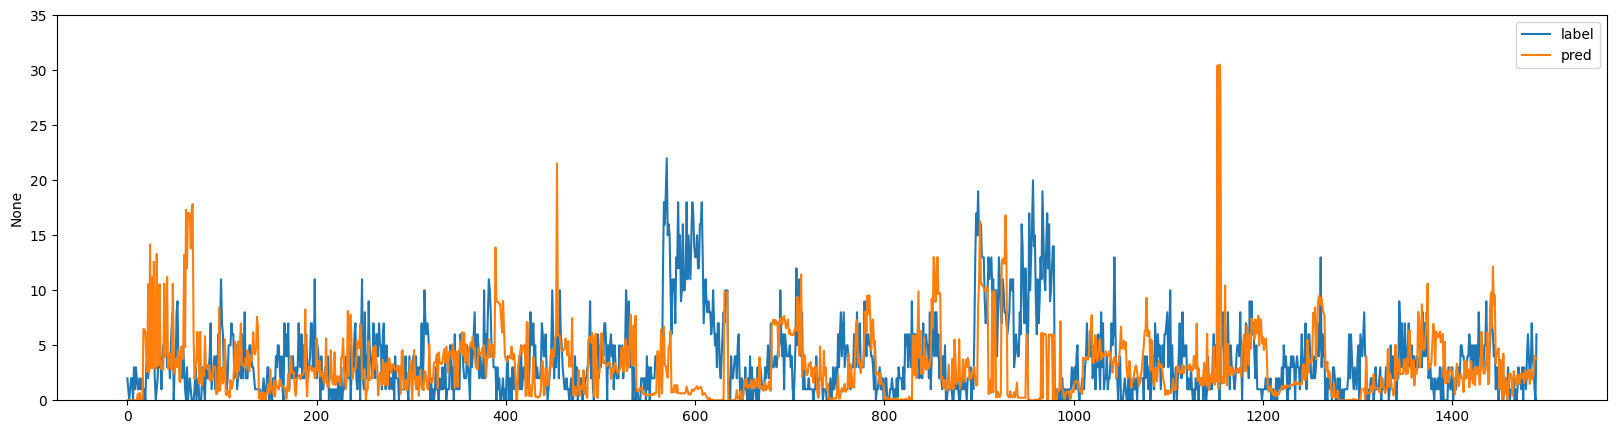

In [13]:
visualize("xgboost", preds, label, -1, 2)

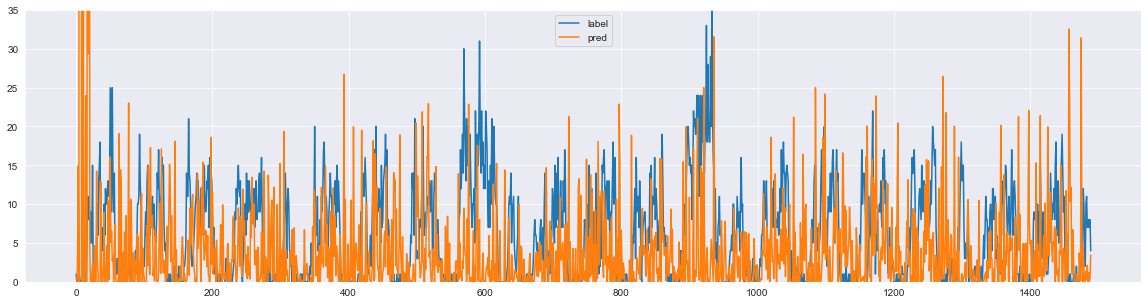

In [128]:
visualize("elm", preds, label, -1, 1)

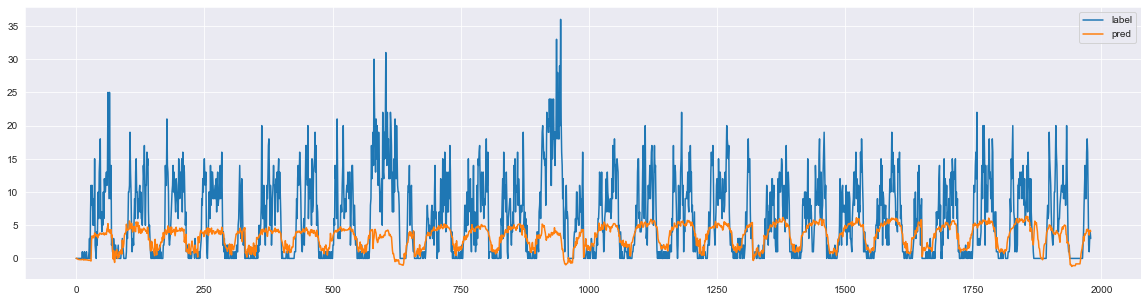

In [9]:
visualize("gat", preds, label, 1, 1)

In [207]:
# error per step
from lib.metric import masked_rmse_np
error_per_step_dict = {}
for mdl in preds.keys():
    pred = np.transpose(preds[mdl], [0, 2, 1, 3]).reshape(-1, preds[mdl].shape[1], preds[mdl].shape[3])
    error_per_step = []
    for i in range(pred.shape[2]): # on step dimension
        error_per_step.append(masked_rmse_np(pred[:, node_of_interest, i], label[:, node_of_interest, i].numpy()))
        # error_per_step.append(np.mean((pred[:, node_of_interest, i] - label[:, node_of_interest, i].numpy()) ** 2))
        # mae
        # error_per_step.append(np.mean(np.abs(pred[:, :, i] - label[:, :, i].numpy())))
    error_per_step_dict[mdl] = np.array(error_per_step)

In [208]:
# overall error
for mdl in model_list:
    pred = np.transpose(preds[mdl], [0, 2, 1, 3]).reshape(-1, preds[mdl].shape[1], preds[mdl].shape[3])
    #rmse
    print(f"{mdl} rmse: {masked_rmse_np(pred[:, node_of_interest, :], label[:, node_of_interest, :].numpy())}")
    # mae
    print(f"{mdl} mae: {np.mean(np.abs(pred - label.numpy()))}")
    

Online_Diffusion rmse: 3.6851963996887207
Online_Diffusion mae: 2.5788204669952393
Online_MA rmse: 4.806061267852783
Online_MA mae: 2.8695249557495117
Online_GCN rmse: 5.18980598449707
Online_GCN mae: 4.905062198638916
Online_GAT rmse: 4.4478559494018555
Online_GAT mae: 3.448063611984253
Online_LSTM rmse: 3.6551201343536377
Online_LSTM mae: 2.4181625843048096


Online_Diffusion rmse: 21.954397201538086
Online_MA rmse: 28.637008666992188
Online_GCN rmse: 31.137807846069336
Online_GAT rmse: 26.674041748046875
Online_LSTM rmse: 21.910741806030273


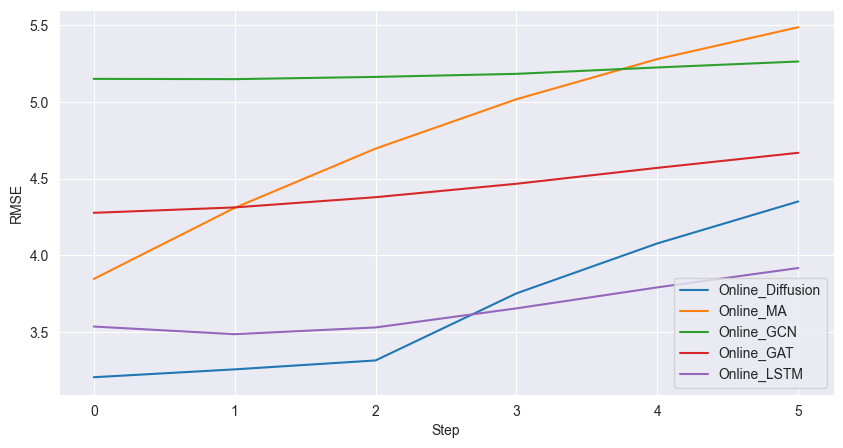

In [209]:
# plot error per step
plt.figure(figsize=(10, 5))
for mdl in error_per_step_dict.keys():
    sns.lineplot(x=np.arange(error_per_step_dict[mdl].shape[0]), y=error_per_step_dict[mdl], label=mdl)
    print(f"{mdl} rmse: {np.sum(error_per_step_dict[mdl])}")
    plt.ylabel("RMSE")
    plt.xlabel("Step")
    # plt.ylim(0, 20)

In [216]:
# plot error per node using pred and label
from lib.metric import masked_rmse_np, masked_mae_np, masked_mape_np

error_per_node_dict = {}
for mdl in preds.keys():
    pred = np.transpose(preds[mdl], [0, 2, 1, 3]).reshape(-1, preds[mdl].shape[1], preds[mdl].shape[3])
    error_per_node = []
    for i in node_of_interest: # on node dimension
        error_per_node.append(masked_rmse_np(pred[:, i, :], label[:, i, :].numpy()))
        # mse
        # error_per_node.append(np.mean((pred[:, i, :] - label[:, i, :].numpy()) ** 2))
        # mape
        # error_per_node.append(masked_mape_np(pred[:, i, :], label[:, i, :].numpy()))
    error_per_node_dict[mdl] = np.array(error_per_node)
    

Online_Diffusion rmse: 48.3159294128418
Online_MA rmse: 60.63717269897461
Online_GCN rmse: 68.31893920898438
Online_GAT rmse: 58.30190658569336
Online_LSTM rmse: 48.398441314697266


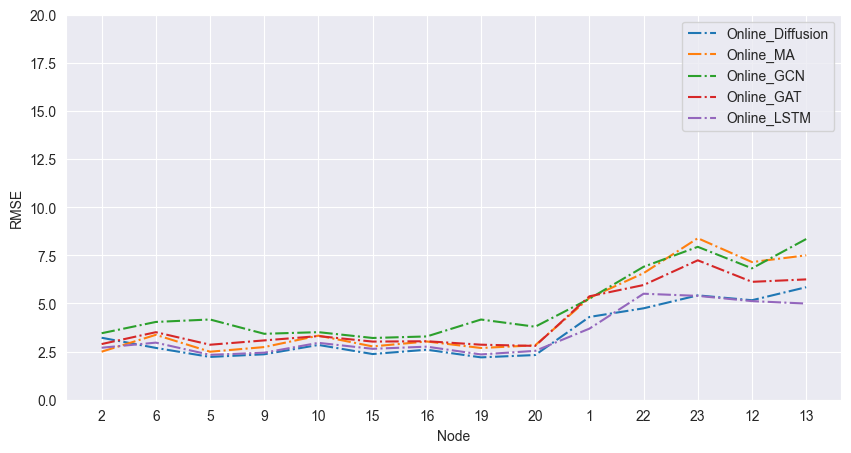

In [217]:
# plot error per node
plt.figure(figsize=(10, 5))
for mdl in error_per_node_dict.keys():
    # change the line style
    sns.lineplot(x=np.arange(error_per_node_dict[mdl].shape[0]), y=error_per_node_dict[mdl], label=mdl, linestyle='-.')
    print(f"{mdl} rmse: {np.sum(error_per_node_dict[mdl])}")
    plt.xticks(np.arange(len(node_of_interest)), node_of_interest)
    plt.ylabel("RMSE")
    plt.xlabel("Node")
    plt.ylim(0, 20)


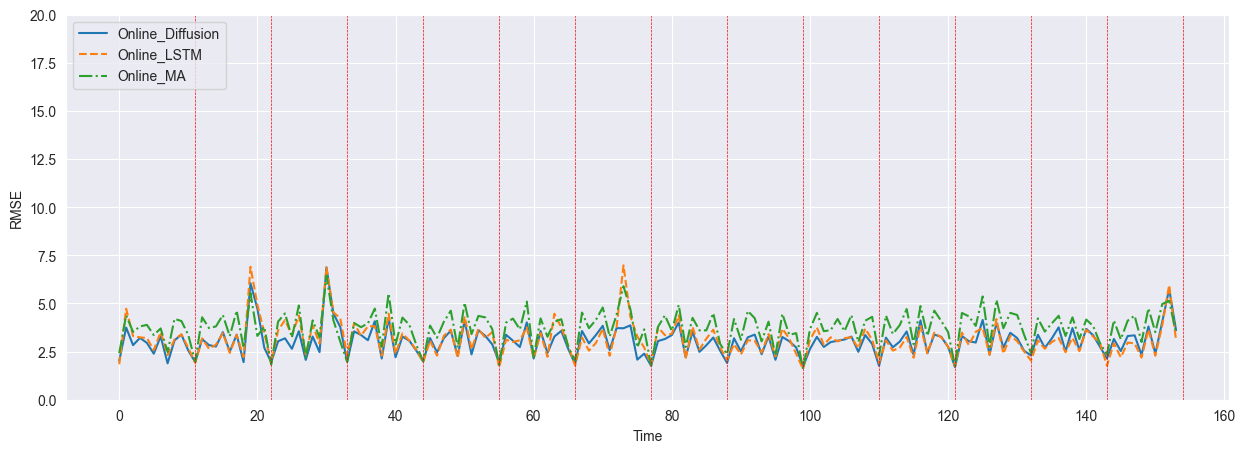

In [180]:
line_types = ['-', '--', '-.', ':', 'dashdot', 'dashdot', 'solid', 'dashdot']
plt.figure(figsize=(15, 5))
mdl_names = ["Online_Diffusion", "Online_LSTM", "Online_MA"]
# for i, mdl_name in enumerate(error_dict.keys()):
for i, mdl_name in enumerate(mdl_names):
    sns.lineplot(x=np.arange(len(error_dict[mdl_name])), y=error_dict[mdl_name][:, 0], label=mdl_name, linestyle=line_types[i])
    plt.ylabel("RMSE")
    plt.xlabel("Time")
    plt.ylim(0, 20)
# plot sc_shift_signal
for i in sc_shift_signal:
    plt.axvline(x=i//chunk_size, color='r', linestyle='--', linewidth=0.5)

    

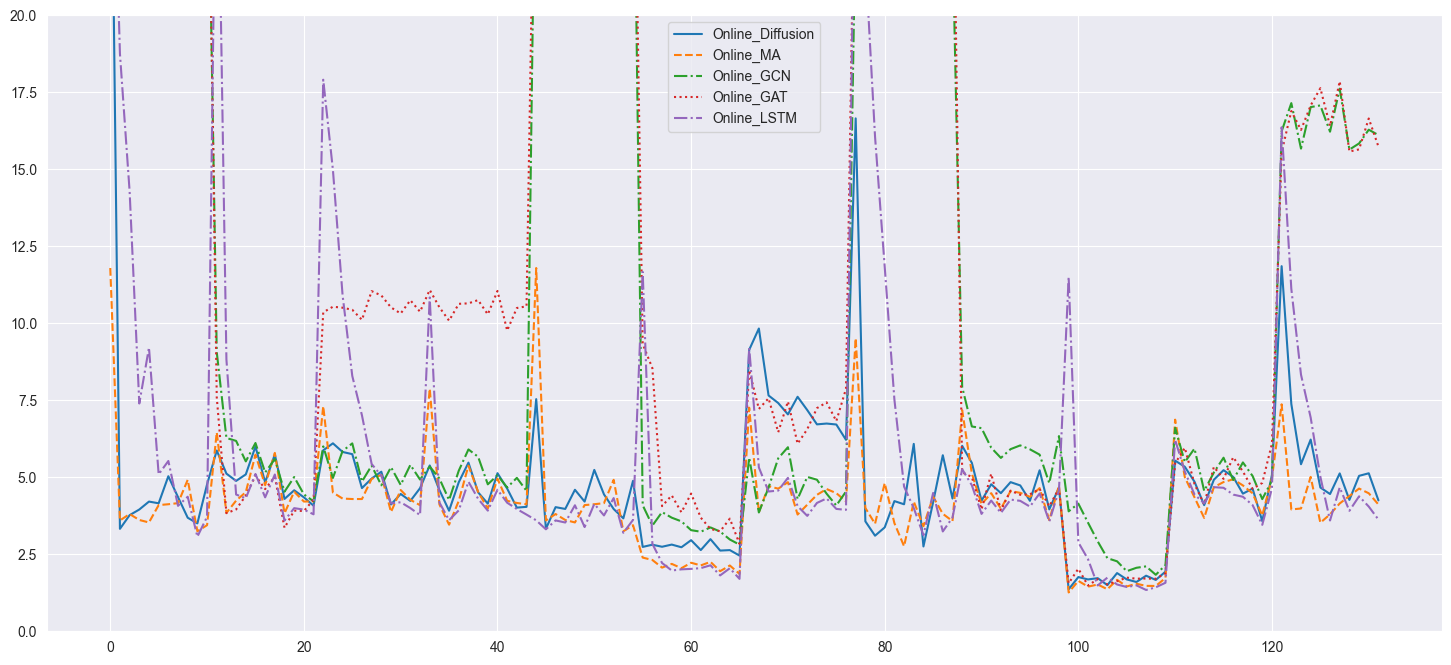

In [66]:
# x = np.arange(len(error_dict["Online_LSTM"]))
line_types = ['-', '--', '-.', ':', 'dashdot', 'dashdot', 'solid', 'dashdot']
plt.figure(figsize=(18, 8))
for i, mdl_name in enumerate(error_dict.keys()):
    sns.lineplot(x=np.arange(len(error_dict[mdl_name])), y=error_dict[mdl_name][:, 0], label=mdl_name, linestyle=line_types[i])
    plt.ylim(0, 20)

In [185]:
preds["Online_Diffusion"].transpose([0, 2, 1, 3]).reshape(-1, label.shape[1], label.shape[2]).shape

(4620, 24, 6)

In [222]:
dataset_name

'train_station'

In [218]:
src, dst = g.edges()

In [44]:
for model_name in error_dict.keys():
    # pred = preds[model_name].transpose([0, 2, 1, 3]).reshape([-1, label.shape[1], label.shape[2]])
    # rmse = np.sqrt(np.mean(pred[dst, :, :] - label.numpy()[dst, :, :]) ** 2)
    # print(f"{model_name} error: {rmse}")
    # stepid = 0
    # rmse_step = np.sqrt(np.mean((pred[dst, :, stepid] - label.numpy()[dst, :, stepid]) ** 2))
    # print(f"{model_name} error: {rmse_step}")
    
    print(f"{model_name} error: {np.mean(error_dict[model_name])}")
    
    

Online_Diffusion error: 3.537405014038086
Online_MA error: 4.6397809982299805
Online_GCN error: 5.044257640838623
Online_GAT error: 4.317541122436523
Online_LSTM error: 3.4886107444763184


In [26]:
dataset_name

'maze'

In [196]:
error_dict["Online_Diffusion"].shape

(154, 6)

In [20]:
stepid = -1
for model_name in error_dict.keys():
    print(f"{model_name} error: {np.mean(error_dict[model_name][:,stepid])}")

Online_Diffusion error: 4.1923112869262695
Online_MA error: 5.342501163482666
Online_GCN error: 5.118371963500977
Online_GAT error: 4.541139125823975
Online_LSTM error: 3.616147518157959


In [16]:
stepid = 4
for model_name in error_dict.keys():
    print(f"{model_name} error: {np.mean(error_dict[model_name][:,stepid])}")

Online_Diffusion error: 3.938019275665283
Online_MA error: 5.134544372558594
Online_GCN error: 5.0781049728393555
Online_GAT error: 4.4455413818359375
Online_LSTM error: 3.4742074012756348


In [67]:
from lib.metric import weighted_average_loss, quantile_loss_np, masked_mae_np, masked_rmse_np
for model_name in error_dict.keys():
    pred = np.transpose(preds[model_name], [0, 2, 3, 1]).reshape(-1, preds[model_name].shape[3], preds[model_name].shape[1], 1)
    target = np.expand_dims(np.transpose(label, [0, 2, 1]), -1)
    mae = masked_mae_np(pred, target)
    rmse = masked_rmse_np(pred, target)
    # l, wt, gamma = weighted_average_loss(pred, target, rho=0.5, timespan=1, mode=0)
    l, wt, gamma = weighted_average_loss(pred[..., :2, :], target[..., :2, :], rho=0.9, timespan=1, mode=0)
    qt_l = quantile_loss_np(pred[..., :2, :], target[..., :2, :], 0.9)
    print(f"{model_name} error: {l}, quantile loss: {qt_l}, mae: {mae}, rmse: {rmse}")

Online_Diffusion error: 5.047702431678772, quantile loss: (9.032593, 36.2723991394043), mae: 2.4661364555358887, rmse: 4.642363548278809
Online_LSTM error: 2.4459957480430603, quantile loss: (3.229831, 42.03331871032715), mae: 2.1488735675811768, rmse: 3.4007599353790283


In [122]:
#pred [N, horizon, node, 1
l, wt, gamma = weighted_average_loss(pred, target, rho=0.9, timespan=3, mode=0)
l, wt[-1, 2, 0]

(6.084234737439289, 2.7817131519317626)

In [123]:
quantile_loss_np(pred, target, 0.9)

(10.894815, 24.72950038909912)

## Load Output Data

In [44]:
import numpy as np
v_dict = {}
alpha_dict = {}
e_dict = {}
F_dict = {}
route_flow = {}
route_speed = {}
# dataset = "train_station"
# dataset = "crossroad"
dataset = "maze"
for m in ["Online_Diffusion", "Online_Diffusion_UQ"]:
    error_dict[m] = np.load(f"./checkpoint/{m}_{dataset}_curve_error_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.npy")
    v_dict[m] = np.load(f"./checkpoint/{m}_{dataset}_v_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.npy")
    alpha_dict[m] = np.load(f"./checkpoint/{m}_{dataset}_alpha_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.npy")
    F_dict[m] = np.load(f"./checkpoint/{m}_{dataset}_F_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.npy")
    # route_flow[m] = np.load(f"./checkpoint/{m}_{dataset}_route_flow_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.npy")
    e_dict[m] = np.load(f"./checkpoint/{m}_{dataset}_e_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.npy")
    with open(f"./checkpoint/{m}_{dataset}_route_flow_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.pkl", "rb") as f:
        route_flow[m] = pickle.load(f)   # predicted route flow
    with open(f"./checkpoint/{m}_{dataset}_route_speed_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.pkl", "rb") as f:
        route_speed[m] = pickle.load(f) # predicted route speed


## Speed Model Analysis

In [45]:
# plot x_up, x_down and V
src, dst = g.edges()
x_up = label[:, src, :].mean(axis=-1).numpy().transpose([1, 0])
x_down = label[:, dst, :].mean(axis=-1).numpy().transpose([1, 0])
diff = (x_up - x_down)
pred_speed = v_dict["Online_Diffusion"]
pred_diffusion = F_dict["Online_Diffusion"]
pred_alpha = alpha_dict["Online_Diffusion"]

In [11]:
sc_shift_signal

[330,
 480,
 630,
 960,
 1290,
 1620,
 1950,
 2280,
 2610,
 2940,
 3270,
 3600,
 3930,
 4260,
 4590]

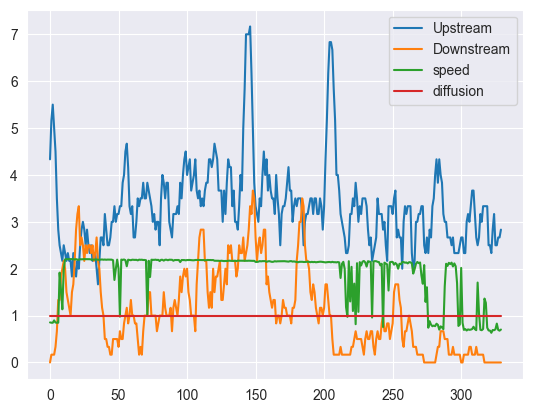

In [46]:
# according to sc_id plot the x_up and x_down and speed, using the sc_shift_signal, sc_id is the index of sc_shift_signal
sc_id = 8

src_idx = 23
dst_idx = 19
edge_id = np.where((src == src_idx) & (dst == dst_idx))[0][0]
# edge_id = 9
if sc_id == 0:
    start = 0
    end = sc_shift_signal[sc_id]
else:
    start = sc_shift_signal[sc_id-1]
    end = sc_shift_signal[sc_id]

plt.plot(np.arange(end - start), x_up[edge_id, start:end], label="Upstream")
plt.plot(np.arange(end - start), x_down[edge_id, start:end], label="Downstream")
plt.plot(np.arange(end - start), pred_speed[edge_id, start:end], label="speed")
plt.plot(np.arange(end - start), pred_diffusion[edge_id, start:end], label="diffusion")
plt.legend()
plt.show()

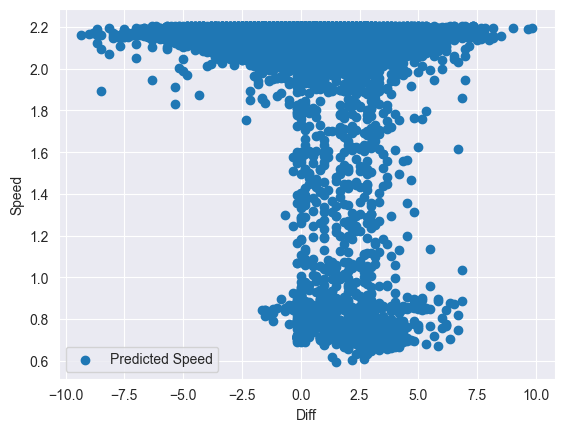

In [47]:
# plt.plot(time, diff[edge_id, :, :].numpy().mean(axis=-1).squeeze(), label=f"Upstream - Downstream Flow")
x = diff[:, start:end].squeeze()
plt.scatter(x, pred_speed[:, start:end].squeeze(), label=f"Predicted Speed")
plt.xlabel('Diff')
plt.ylabel('Speed')
plt.legend()

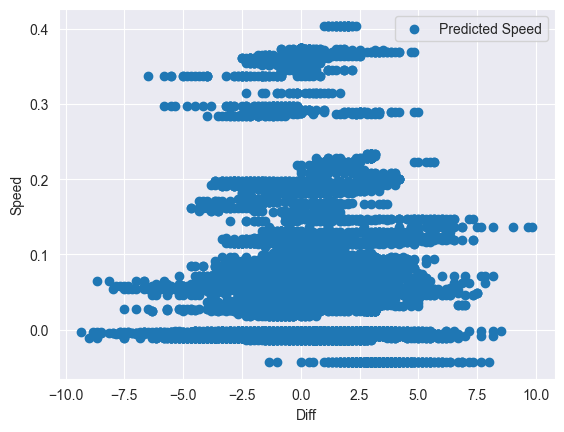

In [217]:
# plot F
plt.scatter(x, pred_alpha[:, start:end].squeeze(), label=f"Predicted Speed")
plt.xlabel('Diff')
plt.ylabel('Speed')
plt.legend()

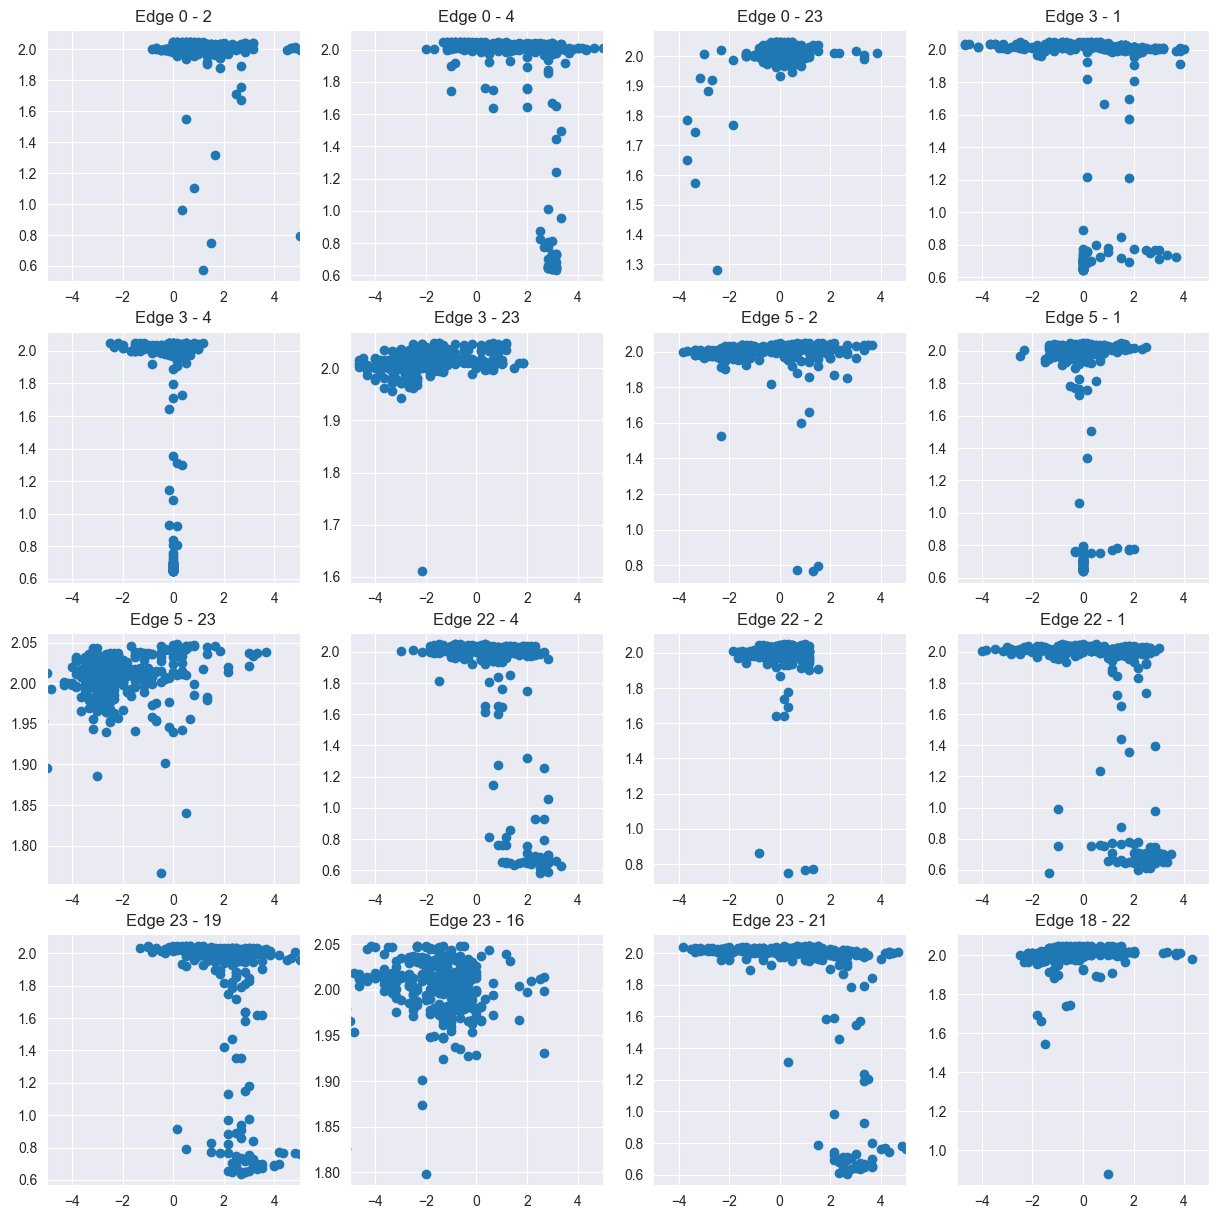

In [204]:
subplot_length = 4
fig, axs = plt.subplots(subplot_length, subplot_length, figsize=(15, 15))
time = np.arange(x_up.shape[1])
diff = (x_up - x_down)
for i in range(subplot_length**2):
    edge_id = i
    # diff = x_up[edge_id, :, :].numpy().mean(axis=-1).squeeze() - x_down[edge_id, :, :].mean(axis=-1).squeeze()
    # axs[i//subplot_length, i%subplot_length].set_xlim(-20, 20) # train_station
    axs[i//subplot_length, i%subplot_length].set_xlim(-5, 5) # maze
    axs[i//subplot_length, i%subplot_length].scatter(diff[edge_id, start:end], pred_speed[edge_id, start:end].squeeze())
    # axs[i//subplot_length, i%subplot_length].scatter(diff[edge_id, start:end], pred_diffusion[edge_id, start:end].squeeze())
    # ylim
    axs[i//subplot_length, i%subplot_length].set_title(f"Edge {src[i]} - {dst[i]}")

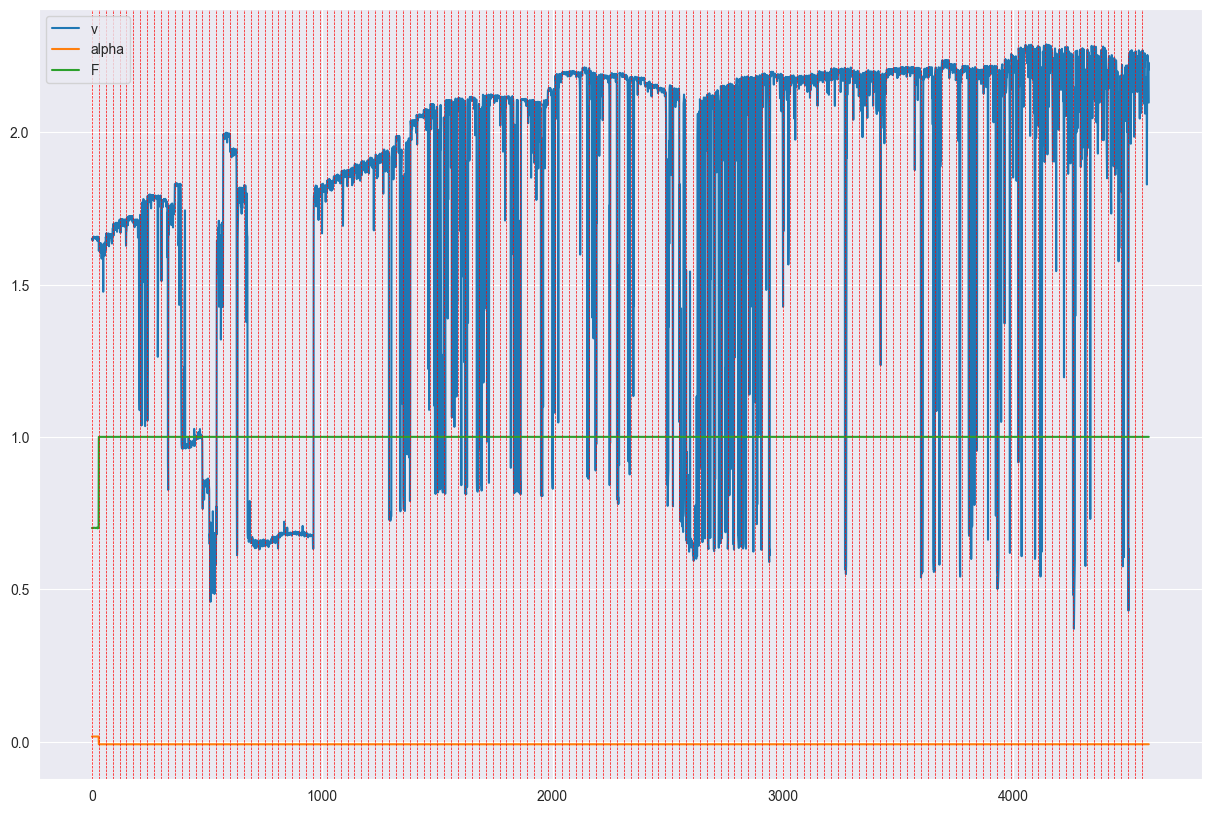

In [214]:
import matplotlib.pyplot as plt
# get the edge id by src and dst
# src = 22
# dst = 2
# try:
#     v = torch.cat(v, dim=1).detach().numpy()
#     alpha = torch.cat(alpha, dim=1).detach().numpy()
# except:
#     pass
# mdl = "Online_Diffusion_UQ"
mdl = "Online_Diffusion"
v = v_dict[mdl]
alpha = alpha_dict[mdl]
F = F_dict[mdl]
# branch_flow = route_flow["Online_Diffusion"]
# branch_flow = branch_flow.transpose([2, 0, 1]).reshape(branch_flow.shape[1], -1)
# edge_id = g.edge_ids(
plt.figure(figsize=(15, 10))
plt.plot(np.arange(v.shape[1]), v[edge_id, :], label="v")
plt.plot(np.arange(alpha.shape[1]), alpha[edge_id, :], label="alpha")
plt.plot(np.arange(F.shape[1]), F[edge_id, :], label="F")
# every 10 steps plot a vertical line
for i in range(0, v.shape[1], chunk_size):
    plt.axvline(x=i, color='r', linestyle='--', linewidth=0.5)
plt.legend()

In [43]:
import pickle
# with open("../nomad/examples/branch_flow_data.pkl", "rb") as f: # not complete version
#     all_scenarios = pickle.load(f)
with open("../nomad/examples/od_data.pkl", "rb") as f: # complete version
    all_scenarios = pickle.load(f)
    
act_list = ["waypoint8", "waypoint3", "waypoint6", "waypoint7", "exit1",
            "exit2", "exit3", "exit4", "exit5", "exit6", "exit7", "exit8"]

gt_flow = all_scenarios["sc_sensor/maze18"]
concat_data = []
for k in all_scenarios.keys():
    concat_data.append(all_scenarios[k])
concat_data = np.concatenate(concat_data, axis=0)
point_to_node = {"waypoint8": [22, 23], "waypoint3": [4, 5], "waypoint6": [16, 17], "waypoint7": [11, 10],
                 "exit1": [21, 20], "exit2": [14, 15], "exit3": [12, 13], "exit4": [8, 9], "exit5": [6,7],
                 "exit6": [2,3], "exit7": [0,1], "exit8": [18,19]}
node_to_point = {22: "waypoint8", 23: "waypoint8", 4: "waypoint3", 5: "waypoint3", 16: "waypoint6", 17: "waypoint6",
                    11: "waypoint7", 10: "waypoint7", 21: "exit1", 20: "exit1", 14: "exit2", 15: "exit2", 12: "exit3",
                    13: "exit3", 8: "exit4", 9: "exit4", 6: "exit5", 7: "exit5", 2: "exit6", 3: "exit6", 0: "exit7",
                    1: "exit7", 18: "exit8", 19: "exit8"}   


In [172]:
# Online Diffusion UQ
# src = 7
# dst = 2
v = v_dict["Online_Diffusion_UQ"]
alpha = alpha_dict["Online_Diffusion_UQ"]
F = F_dict["Online_Diffusion_UQ"]
branch_flow = route_flow["Online_Diffusion_UQ"]
branch_flow = branch_flow.transpose([2, 0, 1]).reshape(branch_flow.shape[1], -1)
edge_id = g.edge_ids(src, dst)
plt.figure(figsize=(15, 10))
plt.plot(np.arange(v.shape[1]), v[edge_id, :], label="v")
plt.plot(np.arange(alpha.shape[1]), alpha[edge_id, :], label="alpha")
# every 10 steps plot a vertical line
for i in range(0, v.shape[1], chunk_size):
    plt.axvline(x=i, color='r', linestyle='--', linewidth=0.5)
plt.legend()

AttributeError: 'dict' object has no attribute 'transpose'

## Compare OD Matrix

In [13]:
# alpha = alpha_dict["diffusion"]
# alpha = alpha_dict["Online_Diffusion"]
# alpha = e_dict["Online_Diffusion"]
# mdl = "Online_Diffusion_UQ"
mdl = "Online_Diffusion"
edge_flows = route_flow[mdl]

In [14]:
edge_flows["sc_sensor/maze18"].shape

(48, 330)

In [94]:
# Estimated edge flows matrix
num_nodes = g.number_of_nodes()
src, dst = g.edges()
sc = "sc_sensor/maze5"

num_edges = len(src)
sample_size = edge_flows[sc].shape[1]  # time length
flow_mat = np.zeros((num_nodes, num_nodes, sample_size))
for i in range(num_edges):
    flow_mat[src[i], dst[i], :] = edge_flows[sc][i, :]

KeyError: 'sc_sensor/maze5'

<Axes: >

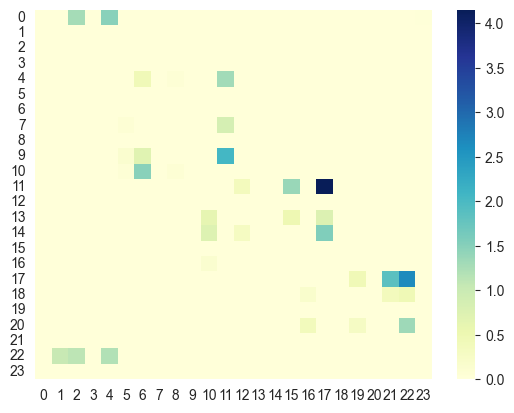

In [16]:
import seaborn as sns
sns.heatmap(flow_mat[..., -1], cmap="YlGnBu")

In [17]:
# visualize attention matrix
# import seaborn as sns
# sns.heatmap(atten_mat[..., -1], cmap="YlGnBu")

In [18]:
# Estimated OD matrix, continue from last cell
od_mat = np.zeros([len(point_to_node), len(point_to_node), flow_mat.shape[-1]])
# translate atten_mat to od_mat:
for n in range(flow_mat.shape[-1]):
    for i in range(flow_mat.shape[0]):
        if np.sum(flow_mat[i, :]) == 0:
            continue
        for j in range(flow_mat.shape[1]):
            src_node = node_to_point[i]  # waypoint
            dst_node = node_to_point[j]
            src_idx = act_list.index(src_node)
            dst_idx = act_list.index(dst_node)
            if flow_mat[i, j, n] != 0:
                od_mat[src_idx, dst_idx, n] = flow_mat[i, j, n]

In [62]:
sc

'sc_sensor/maze16'

In [60]:
# ground truth
gt_flow = all_scenarios[sc]

<Figure size 2000x700 with 0 Axes>

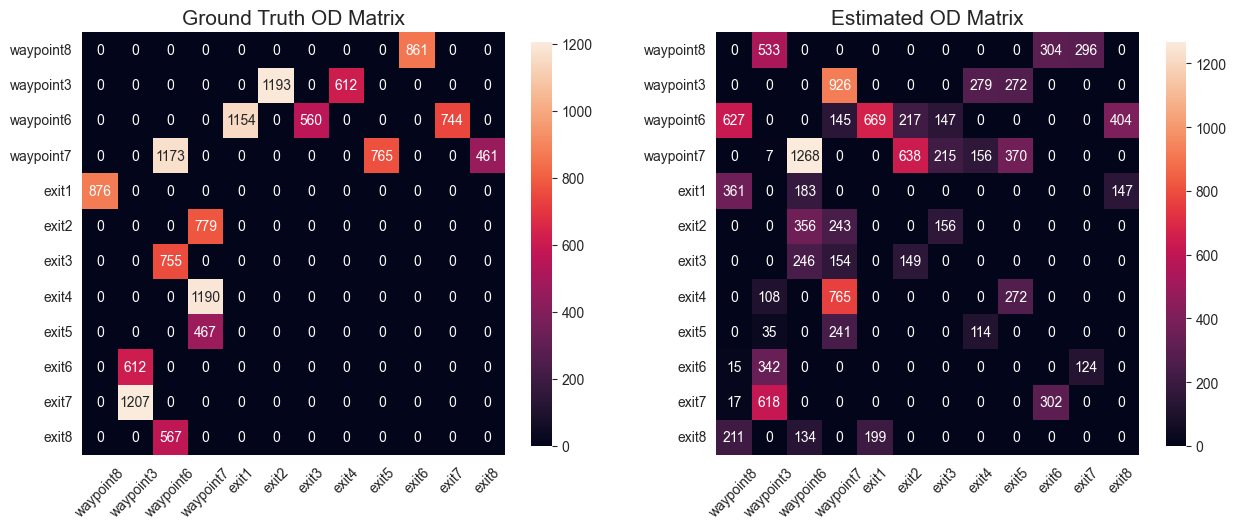

In [61]:
import seaborn as sns
plt.figure(figsize=(20, 7))
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Plot ground truth flow mat, sum over time in one scenario
sns.heatmap(gt_flow[:-chunk_size, ...].sum(axis=0), annot=True, fmt=".0f", xticklabels=act_list,
            yticklabels=act_list, ax=axs[0], square=True, cbar_kws={"shrink": 0.75})
axs[0].set_title('Ground Truth OD Matrix', fontsize=15)
axs[0].tick_params(axis='x', rotation=45)
# Plot predicted flow mat
sns.heatmap(od_mat.sum(axis=-1), annot=True, fmt=".0f", xticklabels=act_list,
            yticklabels=act_list, ax=axs[1], square=True, cbar_kws={"shrink": 0.75})
axs[1].set_title('Estimated OD Matrix', fontsize=15)
axs[1].tick_params(axis='x', rotation=45)

# Display the figure
plt.show()

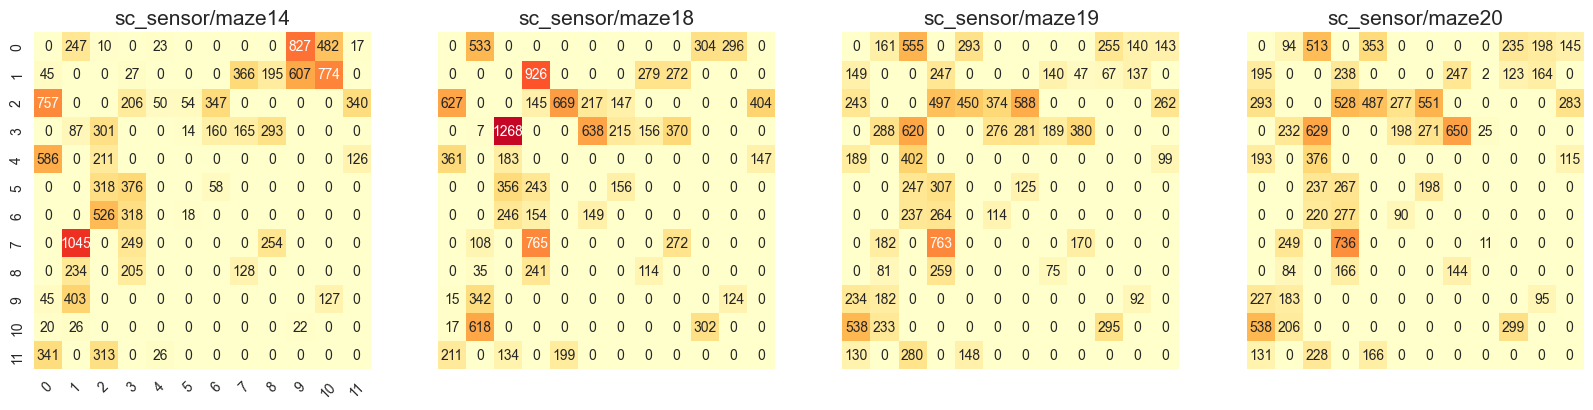

In [95]:
# visualize the change of the od matrix as the scenario changes
# sc_list = ['sc_sensor/maze8', 'sc_sensor/maze8_2', 'sc_sensor/maze10_2', 'sc_sensor/maze18']
sc_list = ['sc_sensor/maze14', 'sc_sensor/maze18', 'sc_sensor/maze19', 'sc_sensor/maze20']


# sc_list = ['sc_sensor/train2', 'sc_sensor/train3', 'sc_sensor/train5', 'sc_sensor/train10']
fig, axs = plt.subplots(1, len(sc_list), figsize=(20, 7))
for sc_num, sc in enumerate(sc_list):
    # num_edges = len(src)
    sample_size = edge_flows[sc].shape[1]  # time length
    flow_mat = np.zeros((num_nodes, num_nodes, sample_size))
    for i in range(num_edges):
        flow_mat[src[i], dst[i], :] = edge_flows[sc][i, :]
    od_mat = np.zeros([len(point_to_node), len(point_to_node), flow_mat.shape[-1]])
    for n in range(flow_mat.shape[-1]):
        for i in range(flow_mat.shape[0]):
            if np.sum(flow_mat[i, :]) == 0:
                continue
            for j in range(flow_mat.shape[1]):
                src_node = node_to_point[i]  # waypoint
                dst_node = node_to_point[j]
                src_idx = act_list.index(src_node)
                dst_idx = act_list.index(dst_node)
                if flow_mat[i, j, n] != 0:
                    od_mat[src_idx, dst_idx, n] = flow_mat[i, j, n]
    if sc_num == 0:
        sns.heatmap(od_mat.sum(axis=-1), annot=True, fmt=".0f",
                     ax=axs[sc_num], square=True, cbar=False, vmax=1500, cmap="YlOrRd")
    else:
        sns.heatmap(od_mat.sum(axis=-1), annot=True, fmt=".0f", xticklabels=False,
                    yticklabels=False, ax=axs[sc_num], square=True, cbar=False, vmax=1500, cmap="YlOrRd")
    axs[sc_num].set_title(f'{sc}', fontsize=15)
    axs[sc_num].tick_params(axis='x', rotation=45)


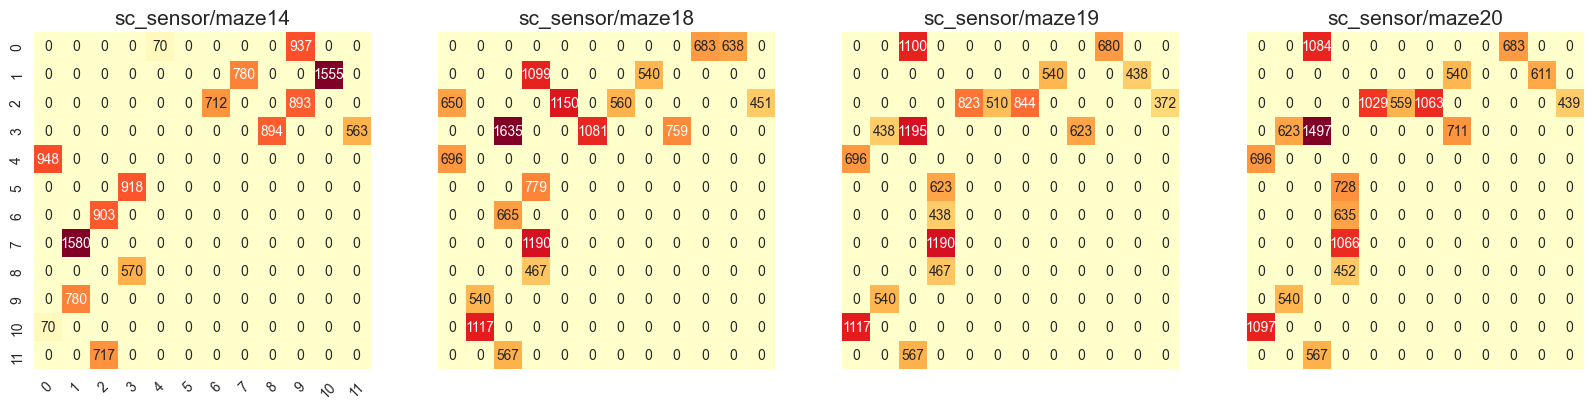

In [96]:
# visualize the ground truth od matrix
fig, axs = plt.subplots(1, len(sc_list), figsize=(20, 7))
for sc_num, sc in enumerate(sc_list):
    gt_flow = all_scenarios[sc][:-chunk_size,...] # same size as the predicted flow
    # adjust the scale of the color
    
    if sc_num == 0:
        sns.heatmap(gt_flow.sum(axis=0), annot=True, fmt=".0f"
                    , ax=axs[sc_num], square=True, cbar=False, vmax=1500, cmap="YlOrRd")
    else:
        sns.heatmap(gt_flow.sum(axis=0), annot=True, fmt=".0f", xticklabels=False,
                    yticklabels=False, ax=axs[sc_num], square=True, cbar=False, vmax=1500, cmap="YlOrRd")
    axs[sc_num].set_title(f'{sc}', fontsize=15)
    axs[sc_num].tick_params(axis='x', rotation=45)

## Comare FD

In [48]:
edge_speeds = route_speed[mdl]
edge_flows = route_flow[mdl]
edge_speeds.keys()

dict_keys(['sc_sensor/maze14', 'sc_sensor/maze2', 'sc_sensor/maze3', 'sc_sensor/maze1', 'sc_sensor/maze8', 'sc_sensor/maze17', 'sc_sensor/maze16', 'sc_sensor/maze15', 'sc_sensor/maze19', 'sc_sensor/maze12', 'sc_sensor/maze8_2', 'sc_sensor/maze10_2', 'sc_sensor/maze18', 'sc_sensor/maze13', 'sc_sensor/maze20'])

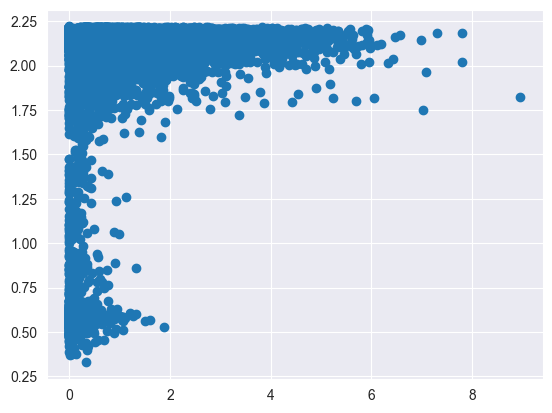

In [49]:
sc = "sc_sensor/maze18"
pred_speed = edge_speeds[sc]
pred_flow = edge_flows[sc]
plt.plot(pred_flow.reshape(-1), pred_speed.reshape(-1), 'o')

In [63]:
with open("../nomad/examples/fd_data.pkl", "rb") as f:
    fd_all_scenarios = pickle.load(f)
with open("../nomad/examples/new_fd_data.pkl", "rb") as f:
    new_fd_data = pickle.load(f)

## Analyze F and Alpha with GT Flow

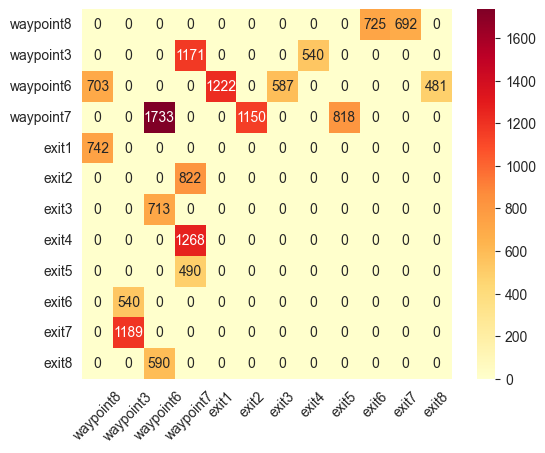

In [155]:
sc = "sc_sensor/maze18"
gt_od = all_scenarios[sc]
ax = sns.heatmap(gt_od.sum(axis=0), annot=True, fmt=".0f", cmap="YlOrRd", xticklabels=act_list, yticklabels=act_list,
                    square=True)
ax.tick_params(axis='x', rotation=45)
plt.show()

In [168]:
# ground truth route flow vs F and alpha
right = sc_shift_signal[test_sc.index(sc)]
if test_sc.index(sc) == 0:
    left = 0
else:
    left = sc_shift_signal[test_sc.index(sc)-1]
scenario_F = F_dict["Online_Diffusion"][:, left:right]
scenario_alpha = alpha_dict["Online_Diffusion"][:, left:right]
sc_label = label[left:right, :, 0].numpy()
sc_pred = preds["Online_Diffusion"].transpose([0, 2, 1, 3]).reshape(-1, preds["Online_Diffusion"].shape[1], preds["Online_Diffusion"].shape[3])[left:right, :, 0]
scenario_flow = new_fd_data[sc]["flow"][:scenario_F.shape[1], :, :].transpose([1, 2, 0])
left, right

(3600, 3930)

In [158]:
# Continue from last cell
sample_size = scenario_F.shape[1]
F_mat = np.zeros((num_nodes, num_nodes, sample_size))
alpha_mat = np.zeros((num_nodes, num_nodes, sample_size))
for i in range(num_edges):
    F_mat[src[i], dst[i], :] = scenario_F[i, :]
    alpha_mat[src[i], dst[i], :] = scenario_alpha[i, :]

In [159]:
# translate F_mat to F_od_mat
F_od_mat = np.zeros([len(point_to_node), len(point_to_node), sample_size])
alpha_od_mat = np.zeros([len(point_to_node), len(point_to_node), sample_size])
for n in range(sample_size):
    for i in range(F_mat.shape[0]):
        if np.sum(flow_mat[i, :]) == 0: # no flow
            continue
        for j in range(F_mat.shape[1]):
            src_node = node_to_point[i]  # waypoint
            dst_node = node_to_point[j]
            src_idx = act_list.index(src_node)
            dst_idx = act_list.index(dst_node)
            if flow_mat[i, j, n] != 0:  # use flow mat here
                F_od_mat[src_idx, dst_idx, n] = F_mat[i, j, n]
                alpha_od_mat[src_idx, dst_idx, n] = alpha_mat[i, j, n]



Text(0, 0.5, 'F')

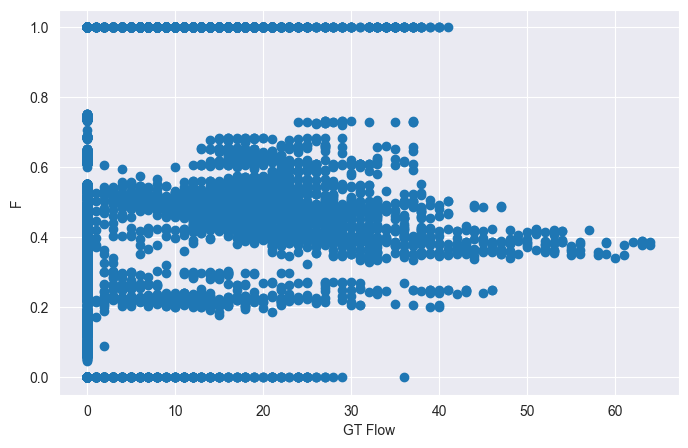

In [160]:
# plot relationship between F and GT flow
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 5))
plt.scatter(scenario_flow.reshape(-1), F_od_mat.reshape(-1), marker='o')
plt.xlabel("GT Flow")
plt.ylabel("F")

In [169]:
sc_pred.shape

(330, 24)

Text(0.5, 1.0, 'GT Flow waypoint6 to waypoint7, scsc_sensor/maze18')

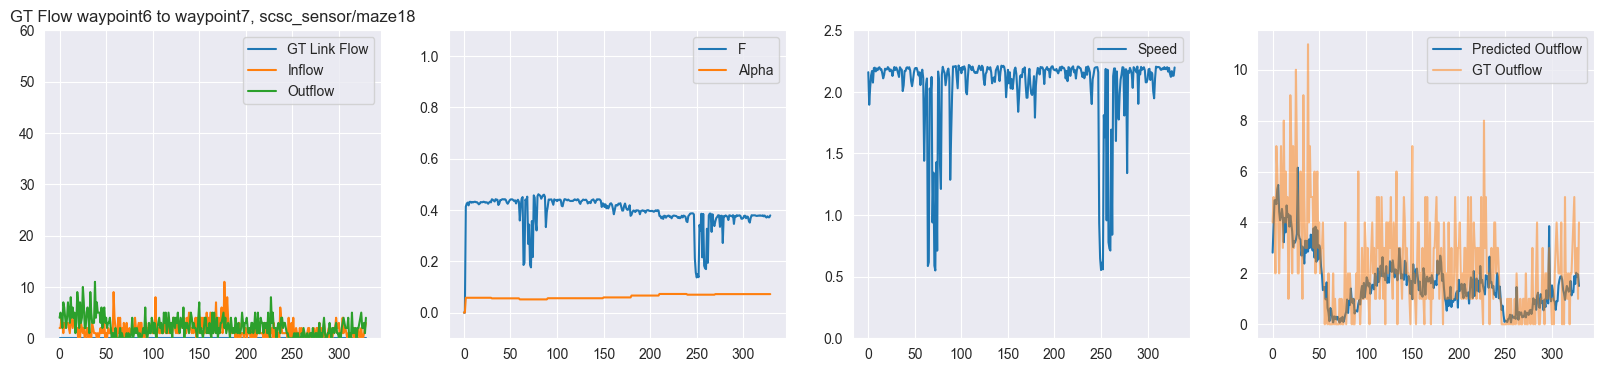

In [188]:
# plot it as time change, use subplot
fig, axs = plt.subplots(1, 4, figsize=(20, 4))
origin = "waypoint6"
# origin = "exit2"
# origin = "waypoint7"
destination = "waypoint7"
# destination = "exit6"
up_id = 16
down_id = 10
edge_id = np.where((src == up_id) & (dst == down_id))[0][0]
row = act_list.index(origin)
col = act_list.index(destination)
flow = scenario_flow[row, col, :]
pred_f = F_od_mat[row, col, :]
pred_alpha = alpha_od_mat[row, col, :]
p_speed = pred_speed[edge_id, :]
axs[0].plot(flow, label="GT Link Flow")
axs[0].plot(sc_label[:, up_id], label="Inflow")
axs[0].plot(sc_label[:, down_id], label="Outflow")
axs[1].plot(pred_f, label="F")
axs[1].plot(pred_alpha, label="Alpha")
axs[2].plot(p_speed, label="Speed")
axs[3].plot(sc_pred[:, down_id], label="Predicted Outflow")
axs[3].plot(sc_label[:, down_id], label="GT Outflow", alpha=0.5)


axs[0].set_ylim(0, 60)
axs[1].set_ylim(-0.1, 1.1)
axs[2].set_ylim(0, 2.5)
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()
# set title for the plot
axs[0].set_title(f"GT Flow {origin} to {destination}, sc{sc}")



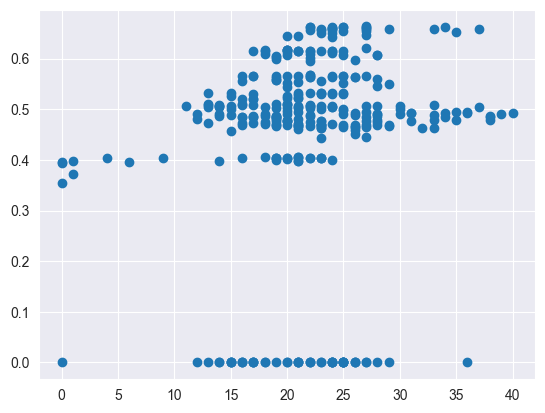

In [178]:
plt.scatter(flow, pred_f, marker='o')

## Visualize FD

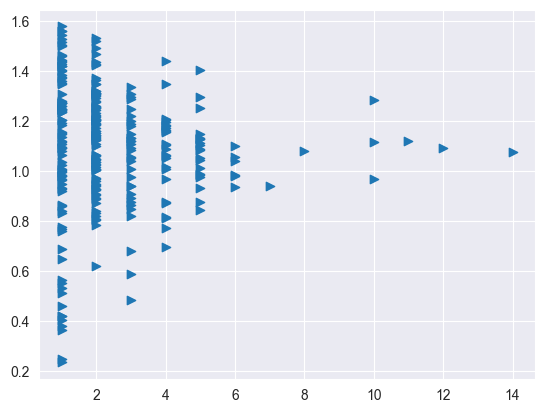

In [292]:
fd = fd_all_scenarios[sc]
OD_names = 'waypoint6|waypoint8'
sub_df = fd[fd.index.get_level_values("OD")==OD_names]
# sub_df = fd
flow = sub_df["f"].values
speed = sub_df["s"].values
plt.scatter(flow, speed, marker='>')
plt.show()

In [294]:
new_fd['flow'].shape

(360, 12, 12)

In [297]:
sub_df["flow"][:, row, col].shape

(360,)

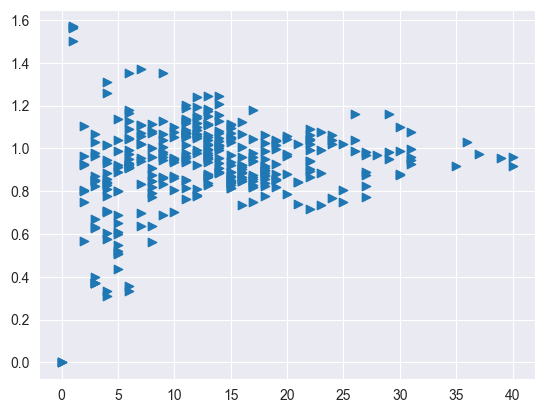

In [295]:
new_fd = new_fd_data[sc]
OD_names = 'waypoint6|waypoint8'
# sub_df = fd[fd.index.get_level_values("OD")==OD_names]
sub_df = new_fd
flow = sub_df["flow"][:, row, col].reshape(-1)
speed = sub_df["speed"][:, row, col].reshape(-1)
# flow = sub_df["flow"].reshape(-1)
# speed = sub_df["speed"].reshape(-1)
plt.scatter(flow, speed, marker='>')
plt.show()


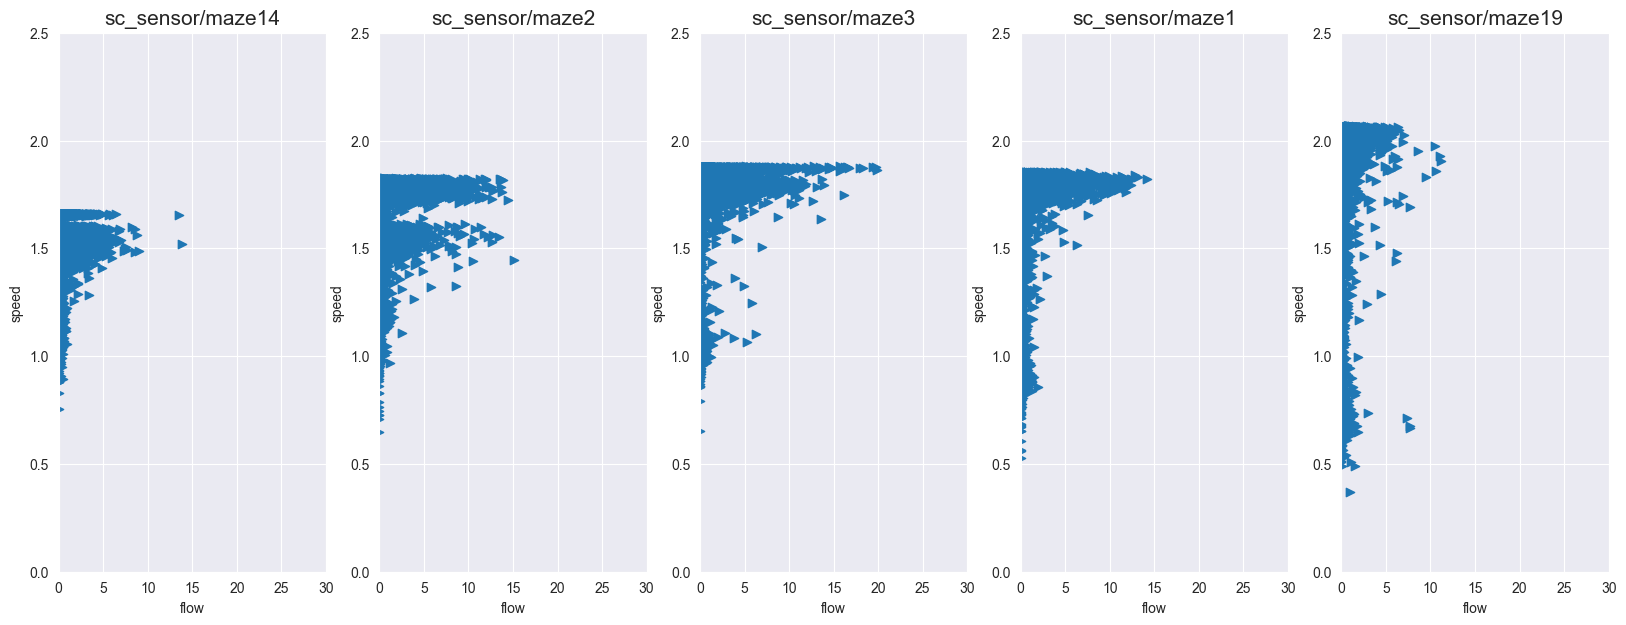

In [281]:
# plot estimated FD
sc_list = ['sc_sensor/maze14', 'sc_sensor/maze2', 'sc_sensor/maze3', 'sc_sensor/maze1', 'sc_sensor/maze19']
# sc_list = ['sc_sensor/train2', 'sc_sensor/train3', 'sc_sensor/train5', 'sc_sensor/train10']
fig, axs = plt.subplots(1, len(sc_list), figsize=(20, 7))

for sc in sc_list:
    pred_speed = edge_speeds[sc]
    pred_flow = edge_flows[sc]
    axs[sc_list.index(sc)].scatter(pred_flow.reshape(-1), pred_speed.reshape(-1), marker='>')
    axs[sc_list.index(sc)].set_title(f'{sc}', fontsize=15)
    #ylim
    axs[sc_list.index(sc)].set_ylim(0, 2.5)
    #xlim
    axs[sc_list.index(sc)].set_xlim(0, 30)
    axs[sc_list.index(sc)].set_xlabel("flow")
    axs[sc_list.index(sc)].set_ylabel("speed")
    

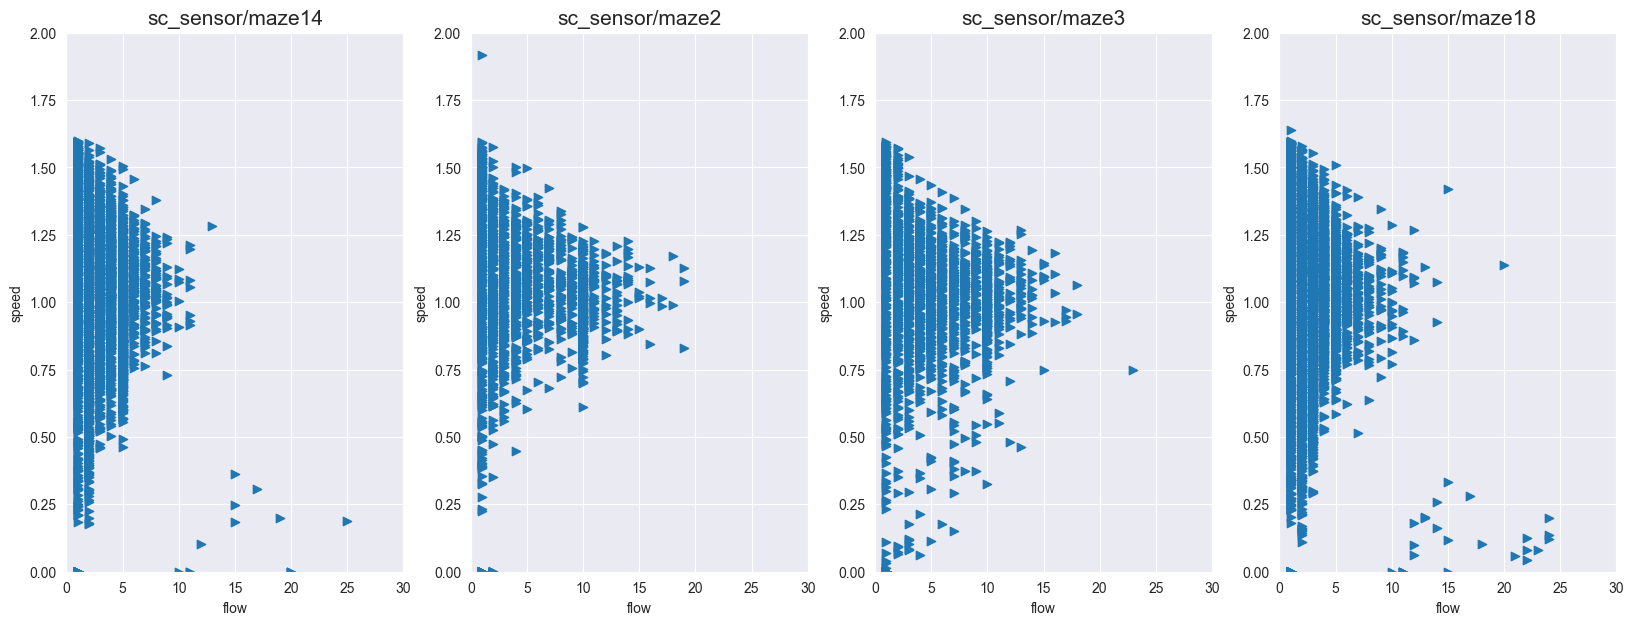

In [289]:
# plot all scenarios
fig, axs = plt.subplots(1, len(sc_list), figsize=(20, 7))
for sc in sc_list:
    fd = fd_all_scenarios[sc]
    sub_df = fd
    flow = sub_df["f"].values
    speed = sub_df["s"].values
    axs[sc_list.index(sc)].scatter(flow, speed, marker='>')
    # ylim
    axs[sc_list.index(sc)].set_ylim(0, 2)
    # xlim
    axs[sc_list.index(sc)].set_xlim(0, 30)
    axs[sc_list.index(sc)].set_title(f'{sc}', fontsize=15)
    axs[sc_list.index(sc)].set_xlabel("flow")
    axs[sc_list.index(sc)].set_ylabel("speed")

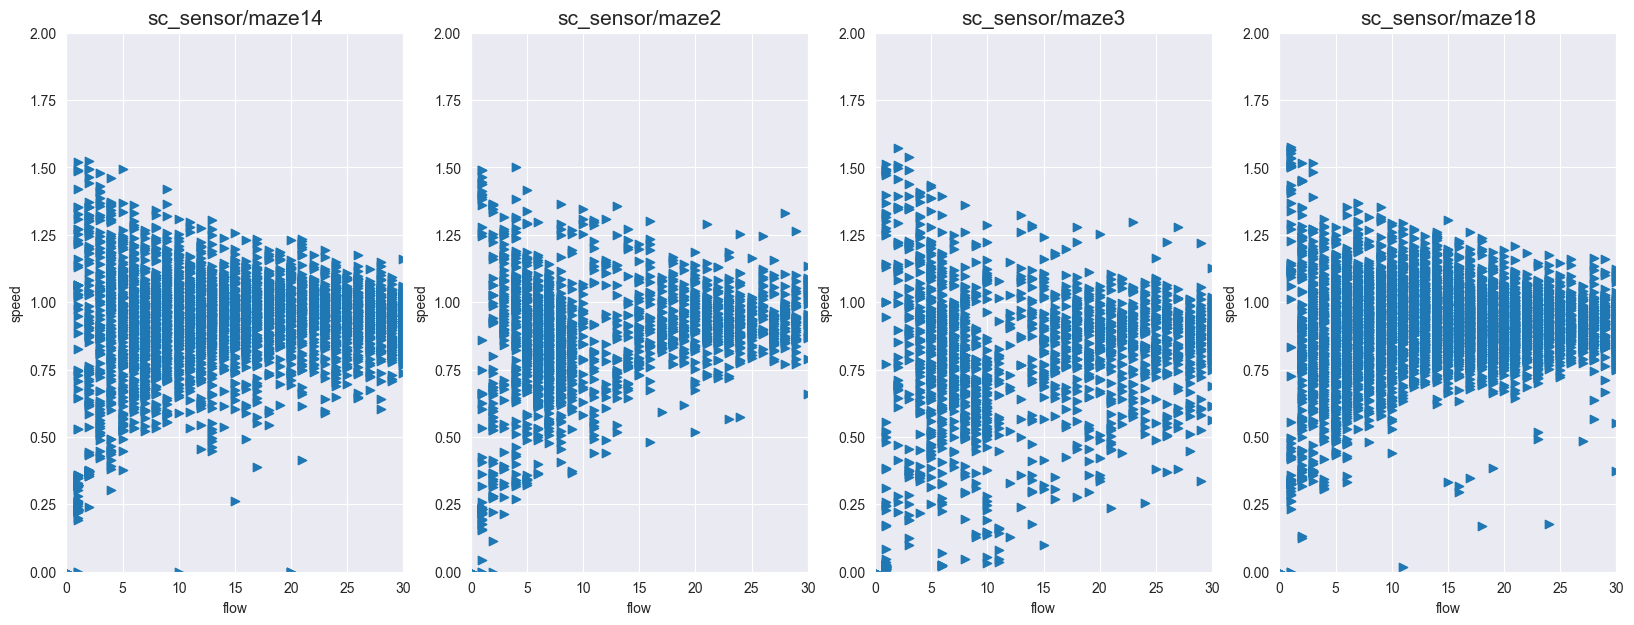

In [290]:
# version 2
fig, axs = plt.subplots(1, len(sc_list), figsize=(20, 7))
for sc in sc_list:
    new_fd = new_fd_data[sc]
    flow = new_fd["flow"].reshape(-1)
    speed = new_fd["speed"].reshape(-1)
    axs[sc_list.index(sc)].scatter(flow, speed, marker='>')
    # ylim
    axs[sc_list.index(sc)].set_ylim(0, 2)
    # xlim
    axs[sc_list.index(sc)].set_xlim(0, 30)
    axs[sc_list.index(sc)].set_title(f'{sc}', fontsize=15)
    axs[sc_list.index(sc)].set_xlabel("flow")
    axs[sc_list.index(sc)].set_ylabel("speed")

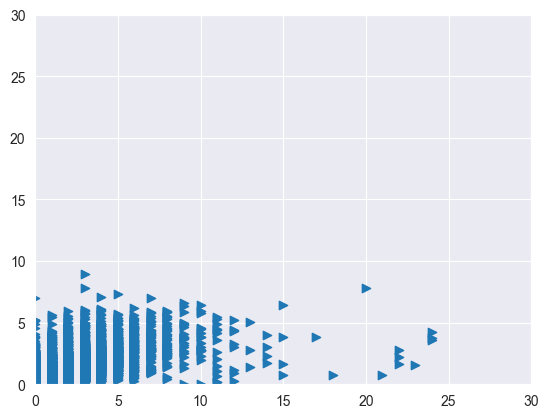

In [291]:
# plot the linear relationship between gt_f and p_f
gt_f = gt_flow[:od_mat.shape[2], :, :].transpose([1, 2, 0]).reshape(-1, od_mat.shape[2])
p_f = od_mat.reshape(-1, od_mat.shape[2])
#xlim
plt.xlim(0, 30)
#ylim
plt.ylim(0, 30)
plt.scatter(gt_f, p_f, marker='>')
plt.show()
